###TAXI WEEK #4 SHITKOV

In [0]:
%pylab inline
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
from google.colab import drive
drive.mount('/content/gdrive')
!pip install geojson
import folium
import geojson
from geojson import Feature, Polygon, FeatureCollection
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import fcluster

Populating the interactive namespace from numpy and matplotlib
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


* Результатом этой недели будут построенные с помощью ARIMA почасовые прогнозы количества поездок для всех географических зон Нью-Йорка;
* Модель, которую мы строим, должна делать почасовые прогнозы для всех выбранных непустых ячеек на 6 часов вперёд;
* Качество модели мы будем оценивать с помощью среднего абсолютного отклонения от истинного количества поездок;
* Построенные прогнозы вам предстоит загрузить на kaggle;

####Ячейки из второй недели:

In [0]:
#Загрузить агрегированные данные за май 2016:
filepath = '/content/gdrive/My Drive/ml/'
filename = '2016-5.csv'
data = pd.read_csv(filepath + filename, index_col = 0)
data_arr = data.to_numpy()
data_mean = np.asarray([data_arr.T[i].mean() for i in range(len(data_arr.T))])

#Все ячейки
all_regions = list(data.columns)

#Индексы ячеек
ind = np.asarray([i if (data_mean >= 5)[i] == True else 0 for i in range(len(data_mean))])
ind = ind[ind > 0]
ind = data.columns[ind]
cells = list(ind)

#Список ячеек для удаления из датасета:
rem = np.asarray([-1 if (data_mean > 5)[i] == True else i for i in range(len(data_mean))])
rem[rem >= 0]
rem = data.columns[rem]
rem = list(rem)

#Удалить ячейки из датасета
data.drop(rem, axis='columns', inplace=True)
data_2016_5 = data

####1. Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки.

In [0]:
#Загрузить агрегированные данные за апрель 2016:
filepath = '/content/gdrive/My Drive/ml/'
filename = '2016-4.csv'
data = pd.read_csv(filepath + filename, index_col = 0)
data = pd.DataFrame(data, index = [datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data.index])
#Удалить ячейки из датасета
data.drop(rem, axis='columns', inplace=True)
data.head()

,region_1075,region_1076,region_1077,region_1125,region_1126,region_1127,region_1128,region_1129,region_1130,region_1131,region_1132,region_1172,region_1173,region_1174,region_1175,region_1176,region_1177,region_1178,region_1179,region_1180,region_1181,region_1182,region_1183,region_1184,region_1221,region_1222,region_1223,region_1224,region_1225,region_1227,region_1228,region_1229,region_1230,region_1231,region_1232,region_1233,region_1234,region_1235,region_1272,region_1273,...,region_1376,region_1377,region_1378,region_1380,region_1382,region_1383,region_1384,region_1385,region_1386,region_1387,region_1388,region_1389,region_1390,region_1426,region_1431,region_1434,region_1435,region_1436,region_1437,region_1438,region_1439,region_1441,region_1442,region_1480,region_1482,region_1483,region_1530,region_1532,region_1533,region_1580,region_1630,region_1684,region_1733,region_1734,region_1783,region_2068,region_2069,region_2118,region_2119,region_2168
2016-04-01 00:00:00,46.0,55.0,31.0,67.0,171.0,300.0,521.0,603.0,716.0,161.0,10.0,9.0,18.0,23.0,9.0,36.0,611.0,804.0,512.0,634.0,448.0,379.0,105.0,4.0,6.0,6.0,19.0,38.0,2.0,387.0,608.0,549.0,862.0,709.0,1045.0,447.0,153.0,62.0,12.0,27.0,...,39.0,16.0,8.0,9.0,14.0,70.0,217.0,48.0,24.0,30.0,20.0,15.0,14.0,15.0,12.0,1.0,4.0,31.0,26.0,10.0,4.0,6.0,11.0,6.0,14.0,7.0,9.0,11.0,18.0,2.0,4.0,0.0,2.0,158.0,50.0,104.0,14.0,175.0,53.0,96.0
2016-04-01 01:00:00,25.0,44.0,16.0,46.0,90.0,228.0,325.0,436.0,598.0,121.0,3.0,6.0,20.0,20.0,6.0,24.0,500.0,468.0,302.0,300.0,213.0,278.0,140.0,1.0,6.0,9.0,13.0,19.0,4.0,308.0,414.0,359.0,518.0,463.0,616.0,221.0,91.0,25.0,10.0,14.0,...,44.0,22.0,10.0,11.0,6.0,41.0,126.0,39.0,20.0,18.0,16.0,12.0,17.0,8.0,17.0,1.0,8.0,23.0,20.0,9.0,4.0,4.0,3.0,8.0,10.0,5.0,8.0,7.0,11.0,4.0,8.0,0.0,4.0,3.0,16.0,67.0,14.0,165.0,13.0,68.0
2016-04-01 02:00:00,12.0,23.0,13.0,20.0,58.0,146.0,177.0,299.0,557.0,55.0,1.0,3.0,10.0,9.0,2.0,30.0,300.0,291.0,187.0,190.0,161.0,217.0,162.0,0.0,2.0,9.0,14.0,18.0,0.0,254.0,294.0,239.0,290.0,296.0,347.0,120.0,39.0,14.0,6.0,6.0,...,36.0,18.0,10.0,8.0,4.0,13.0,66.0,29.0,6.0,17.0,15.0,13.0,10.0,9.0,8.0,0.0,3.0,15.0,18.0,6.0,7.0,0.0,3.0,7.0,9.0,7.0,8.0,16.0,13.0,2.0,9.0,0.0,0.0,0.0,1.0,18.0,2.0,26.0,0.0,7.0
2016-04-01 03:00:00,8.0,9.0,4.0,20.0,32.0,141.0,70.0,164.0,498.0,52.0,1.0,0.0,3.0,3.0,0.0,20.0,241.0,162.0,115.0,131.0,88.0,153.0,86.0,2.0,1.0,6.0,7.0,6.0,1.0,187.0,209.0,143.0,169.0,202.0,283.0,107.0,24.0,17.0,5.0,6.0,...,32.0,13.0,7.0,0.0,3.0,27.0,54.0,11.0,13.0,15.0,10.0,12.0,4.0,8.0,6.0,1.0,3.0,9.0,16.0,3.0,6.0,2.0,6.0,5.0,5.0,6.0,6.0,12.0,12.0,2.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0
2016-04-01 04:00:00,9.0,13.0,4.0,16.0,33.0,115.0,55.0,129.0,239.0,21.0,0.0,0.0,7.0,2.0,0.0,13.0,137.0,102.0,85.0,102.0,120.0,136.0,32.0,0.0,1.0,2.0,7.0,7.0,1.0,91.0,148.0,133.0,143.0,159.0,268.0,90.0,27.0,14.0,1.0,0.0,...,20.0,3.0,4.0,3.0,3.0,24.0,80.0,26.0,10.0,10.0,11.0,7.0,9.0,4.0,10.0,0.0,5.0,20.0,11.0,10.0,10.0,4.0,3.0,13.0,28.0,11.0,15.0,14.0,10.0,6.0,8.0,1.0,3.0,3.0,2.0,1.0,0.0,10.0,0.0,1.0


####2. Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на корень из выборочной дисперсии).

In [0]:
# выборочное среднее ряда - .mean()
col = list(data.columns)
col_mean = [data[col[i]].mean() for i in range(len(col))]
# корень(выборочая дисперсия ряда) - .std()
col_std  = [data[col[i]].std() for i in range(len(col))]
# стандартизация
for i in range(len(col)):
  data[col[i]] = (data[col[i]] - col_mean[i])/col_std[i]

In [0]:
data.head()

,region_1075,region_1076,region_1077,region_1125,region_1126,region_1127,region_1128,region_1129,region_1130,region_1131,region_1132,region_1172,region_1173,region_1174,region_1175,region_1176,region_1177,region_1178,region_1179,region_1180,region_1181,region_1182,region_1183,region_1184,region_1221,region_1222,region_1223,region_1224,region_1225,region_1227,region_1228,region_1229,region_1230,region_1231,region_1232,region_1233,region_1234,region_1235,region_1272,region_1273,...,region_1376,region_1377,region_1378,region_1380,region_1382,region_1383,region_1384,region_1385,region_1386,region_1387,region_1388,region_1389,region_1390,region_1426,region_1431,region_1434,region_1435,region_1436,region_1437,region_1438,region_1439,region_1441,region_1442,region_1480,region_1482,region_1483,region_1530,region_1532,region_1533,region_1580,region_1630,region_1684,region_1733,region_1734,region_1783,region_2068,region_2069,region_2118,region_2119,region_2168
2016-04-01 00:00:00,-0.514661,-1.030331,-0.999111,-0.047033,-0.243696,0.090810,1.220538,1.179636,1.178311,0.316702,-0.719601,0.699456,-0.109096,-0.110327,-0.079970,1.200294,1.274038,1.256786,0.019193,0.198292,-0.802629,-0.216168,0.068133,-1.077084,0.315458,-0.341826,0.243643,0.991500,-0.604641,1.243822,0.967117,0.410954,0.515431,0.023995,0.666511,-0.360283,-1.031162,-1.041779,0.544502,0.887864,...,1.252459,0.664151,0.111255,0.073294,-0.645893,-1.101251,-0.959921,-1.314154,-0.759594,0.060953,-0.119529,0.222391,-0.028658,1.207667,-0.624369,-1.017222,-0.951573,0.047979,-0.188269,-0.166253,-0.696839,0.261966,1.000953,-0.733328,0.300945,-0.523681,-0.392568,0.639902,0.984236,-0.593666,-0.234425,-0.923903,-0.790043,-0.311282,-0.922534,0.237346,0.515471,0.485838,0.853682,0.858107
2016-04-01 01:00:00,-1.034444,-1.162729,-1.245946,-0.582928,-1.049658,-0.413917,0.091665,0.367612,0.705272,-0.237868,-0.873854,0.129978,0.017596,-0.289369,-0.439835,0.299291,0.844416,0.067320,-0.808530,-0.968180,-1.485306,-0.783543,0.747309,-1.276373,0.315458,-0.050566,-0.216785,-0.445335,-0.185237,0.793320,0.247080,-0.435519,-0.484569,-0.695977,-0.452638,-1.118500,-1.323865,-1.446029,0.278981,0.111843,...,1.493278,1.176405,0.362759,0.407290,-1.137286,-1.280523,-1.361867,-1.377475,-0.953636,-0.697890,-0.512503,-0.204979,0.344242,0.338891,-0.173109,-1.017222,-0.140045,-0.555419,-0.587935,-0.310299,-0.696839,-0.297724,-0.899967,-0.486774,-0.219296,-0.781934,-0.475724,-0.000222,0.155267,-0.270948,0.569318,-0.923903,-0.263591,-1.357705,-1.180686,-0.396846,0.515471,0.354919,-0.675871,0.100423
2016-04-01 02:00:00,-1.356215,-1.415489,-1.295313,-1.246417,-1.368062,-0.988744,-0.760749,-0.298539,0.540910,-1.152909,-0.917926,-0.439500,-0.615864,-0.945857,-0.919655,0.749793,0.070324,-0.559273,-1.261808,-1.352347,-1.636367,-1.126215,1.174220,-1.342803,-0.481489,-0.050566,-0.140047,-0.520958,-1.024046,0.485382,-0.198304,-0.970134,-1.147359,-1.184739,-1.154388,-1.457349,-1.569358,-1.566211,-0.252060,-0.365708,...,1.107968,0.834902,0.362759,-0.093705,-1.260135,-1.453613,-1.626886,-1.447832,-1.632784,-0.761127,-0.610746,-0.062523,-0.525858,0.463002,-0.985378,-1.141505,-1.154455,-1.158817,-0.721157,-0.742437,-0.091623,-1.417105,-0.899967,-0.610051,-0.349356,-0.523681,-0.475724,1.440058,0.392115,-0.593666,0.770253,-0.923903,-1.316495,-1.377958,-1.294576,-1.236721,-1.006110,-1.464860,-1.172976,-1.550245
2016-04-01 03:00:00,-1.455221,-1.583995,-1.443414,-1.246417,-1.626766,-1.023794,-1.377022,-0.954965,0.304391,-1.194502,-0.917926,-1.008978,-1.059286,-1.303942,-1.159565,-0.001043,-0.158033,-1.015943,-1.545599,-1.558401,-1.848432,-1.485741,-0.300562,-1.209944,-0.680725,-0.341826,-0.677213,-1.428433,-0.814343,0.103311,-0.513784,-1.397826,-1.499103,-1.459850,-1.321347,-1.500963,-1.640173,-1.533434,-0.384821,-0.365708,...,0.915313,0.408024,-0.014496,-1.429691,-1.321559,-1.367068,-1.679890,-1.574473,-1.293210,-0.887600,-1.101963,-0.204979,-1.271658,0.338891,-1.165882,-1.017222,-1.154455,-1.611366,-0.854379,-1.174575,-0.293362,-0.857415,-0

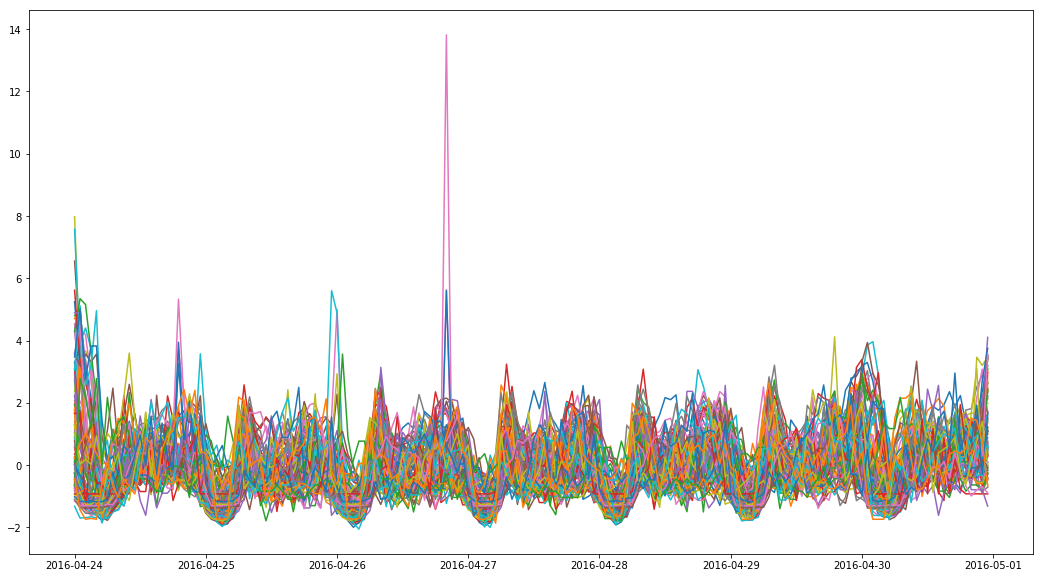

In [0]:
#Визуализация стандартизированых рядов
figure(figsize=(18,10))
for i in list(data.columns):
  plot(data.index[-168:],data[i][-168:])
show()

####3. Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.

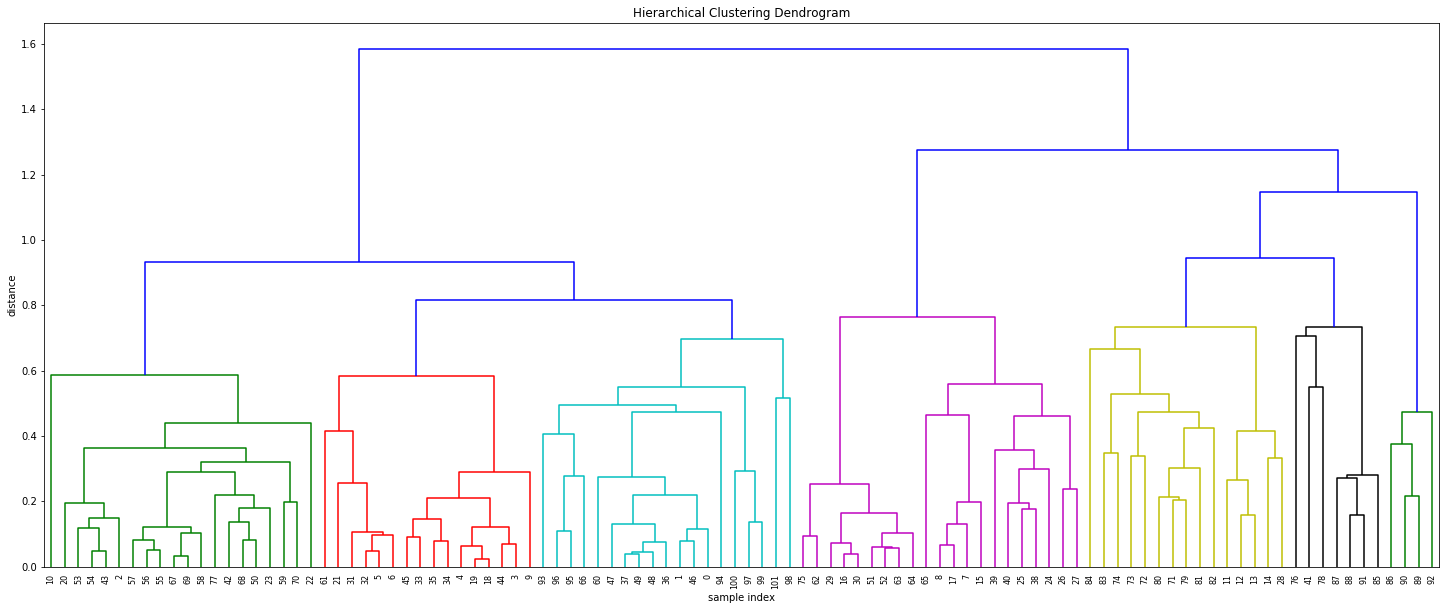

In [0]:
#кластеризация
Z = hac.linkage(data.T, method='complete', metric='correlation', optimal_ordering = True)

# Диаграмма
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    color_threshold = 0.8
)
plt.show()

Исходя из дендрограммы, стоит разделить датасет на 7 кластеров

In [0]:
#Визуализация стандартизированых рядов
k = 7

clusters = fcluster(Z, k, criterion='maxclust')

cl = []

for i in range(1, k + 1):  
  cl.append(data.columns[clusters == i])
  
for c in cl:
  plt.figure(figsize=(15, 10))
  for i in c:
    plot(data.index[-168:],data[i][-168:])
  show()

Output hidden; open in https://colab.research.google.com to view.

####4. В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).

In [0]:
#Визуализация кластеров на карте
regions = pd.read_csv('/content/gdrive/My Drive/ml/' + 'regions.csv', ';')

def coord(i):
  return [[(regions.west[i], regions.south[i]), (regions.west[i], regions.north[i]), (regions.east[i], regions.north[i]), (regions.east[i], regions.south[i])]]

long = (-74.25559 - 73.70001)/2
lat  = (40.49612  + 40.91553)/2 + 0.05

colors = ['#320b8d', '#f0d7d7', '#6f1309', '#ccc867', '#95d24a', '#0edf89', '#1b5d2c']

#Drow map
m = folium.Map(location=[lat,long], zoom_start = 12, no_touch = True)

for i in range(k):
  
  color = colors[i]
  
  folium.Choropleth(
      geo_data=FeatureCollection([Feature(geometry = Polygon(coord(all_regions.index(i) + 1)), id = regions.region[all_regions.index(i) + 1]) for i in cl[i]]),
      columns=['ind', 'qnt'],
      key_on='feature.id',
      fill_color= color,
      #fill_opacity=0.7,
      #line_opacity=0.2    
  ).add_to(m)

m

Что бы выбрать самый характерный ряд, можно:
1. последовать совету, и взять центральный регион из каждого кластера;
2. выбрать ряд, который ближе всего соответствует среднему значению ряда в кластере посчитав расстояние между рядами, взяв ряд как вектор: https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
3. посчитать .corr между столбцами датафрейма для каждого кластера, включив в датафрейм седнее значение ряда

In [0]:
#датафрейм для кластера
df = []
for i in range(1, k + 1):
  df.append(data[data.columns[clusters == i]])

series = []
for i in range(0, k):
  #добавить среднее значение ряда в отдельный столбец mean
  df[i]['mean'] = df[i].mean(axis=1)
  #вычислить меру корреляции
  cdf = df[i].corr()
  cdf = cdf.drop(index = 'mean')
  #выбрать ряд
  series.append(cdf['mean'].idxmax())

print(series)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


['region_1333', 'region_1180', 'region_1234', 'region_1177', 'region_1387', 'region_1530', 'region_1532']


In [0]:
#Отрисовка красным рядов для моделирования
folium.Choropleth(
  geo_data=FeatureCollection([Feature(geometry = Polygon(coord(all_regions.index(series[i]) + 1)), id = regions.region[all_regions.index(series[i]) + 1]) for i in range(len(series))]),
  columns=['ind', 'qnt'],
  key_on='feature.id',
  fill_color= 'red'
).add_to(m)

m


####5. Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров.

In [0]:
#загрузим данные
#агрегированные данные за апрель 2016:
filepath = '/content/gdrive/My Drive/ml/'
filename = '2016-4.csv'
data = pd.read_csv(filepath + filename, index_col = 0)

data = pd.DataFrame(data, index = [datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data.index])

#Создать датафреймы для кажого из выбранных рядов
df = []

for i in range(len(series)):
  df.append(data[[series[i]]])

#Количество создаваемых признаков  
k_features = 20
k_poly = 4

#Столбцы
col = []
  
for i in range(1, k_features + 1):
  col.append(str('sin_' + str(i)))
  col.append(str('cos_' + str(i)))
for i in range(1, k_poly + 1):
  col.append(str('poly_' + str(i)))

#Признаки
features = pd.DataFrame(columns = col, index = data.index)

features['num'] = [int(i) for i in range(1, len(data) + 1)]
for k in range(1, k_features + 1):
  features[str('sin_' + str(k))] = [np.sin(features.num[x] * 2 * np.pi * k / 168) for x in range(len(data))]
  features[str('cos_' + str(k))] = [np.cos(features.num[x] * 2 * np.pi * k / 168) for x in range(len(data))]
  
for k in range(1, k_poly + 1):
  features[str('poly_' + str(k))] = [features.num[x] ** k  for x in range(len(data))]  

#Добавляем признаки к датафреймам с выбранными рядами  
for i in range(len(df)):
  df[i] = pd.concat([df[i], features], axis=1)

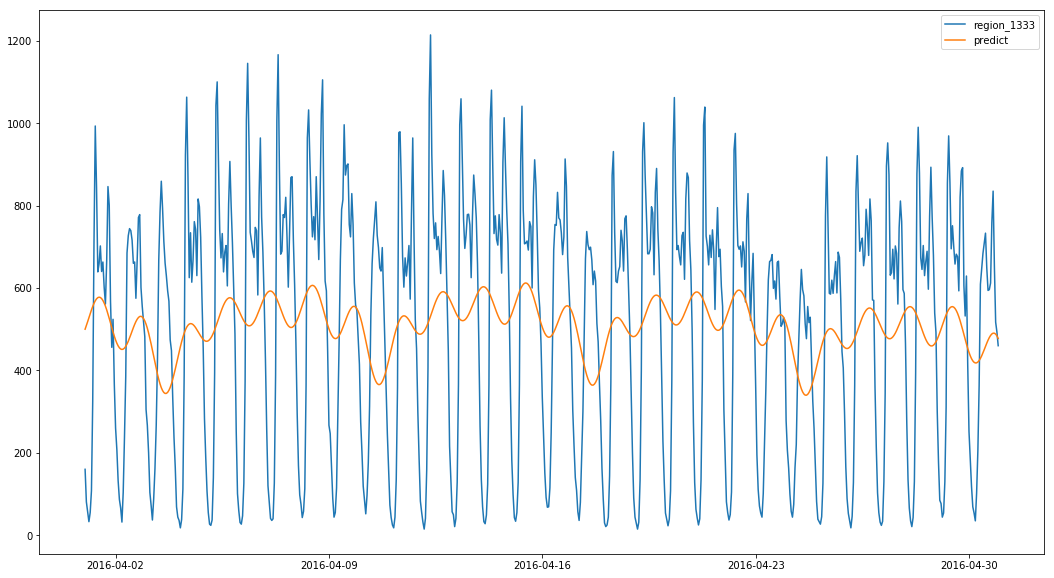

In [0]:
from sklearn import linear_model
#Подбираем количество параметров для регрессии для каждого из выбранных рядов

n_features = 10
n_poly = 2

col_models = []

col_models.append(col[:n_features] + col[-4:-(4 - n_poly)])

#for i in range(len(series)):
for i in range(1):
  X = np.array(df[i][col_models[0]])
  Y = np.array(df[i][series[i]])
  lin_reg = linear_model.LinearRegression()
  lin_reg.fit(X,Y)
  df[i]['predict'] = lin_reg.predict(df[i][col_models[0]])
  df[i]['remains'] = df[i][series[i]] - df[i]['predict']
  
  figure(figsize=(18,10))
  plot(df[i].index,df[i][series[i]])
  plot(df[i].index,df[i]['predict'])
  legend()

show()

In [0]:
n_features = 10
n_poly = 2

col_models = []

col_models.append(col[:n_features] + col[-4:-(4 - n_poly)])
features[col_models[0]].head()

,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3,sin_4,cos_4,sin_5,cos_5,poly_1,poly_2
2016-04-01 00:00:00,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,1,1
2016-04-01 01:00:00,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,2,4
2016-04-01 02:00:00,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,3,9
2016-04-01 03:00:00,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,4,16
2016-04-01 04:00:00,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,5,25


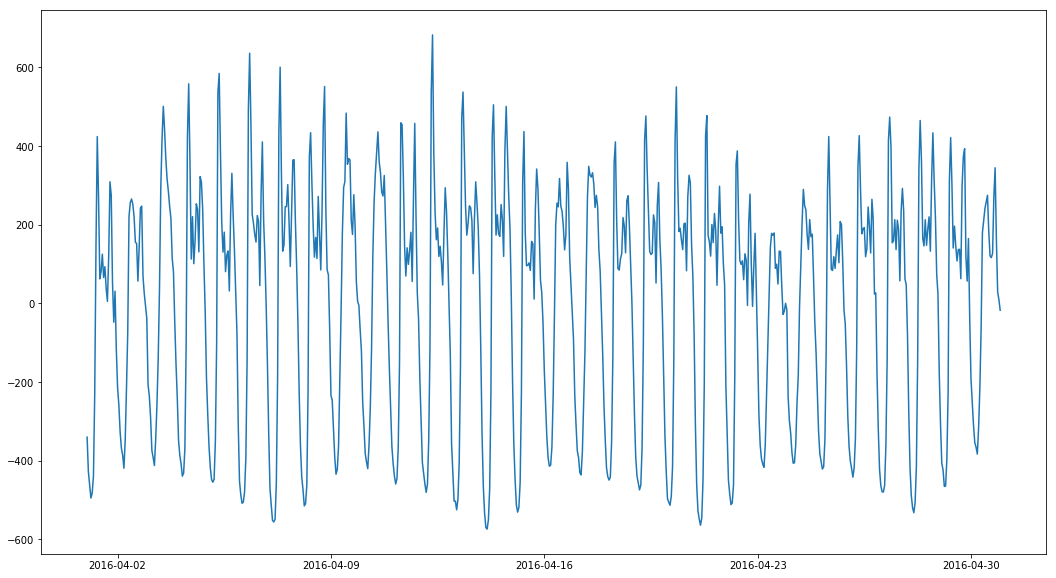

In [0]:
#остатки
df[0]['remains'] = df[0][series[i]] - df[0]['predict']

figure(figsize=(18,10))
plot(df[0].index,df[0].remains)
show()

<Figure size 1296x1152 with 0 Axes>

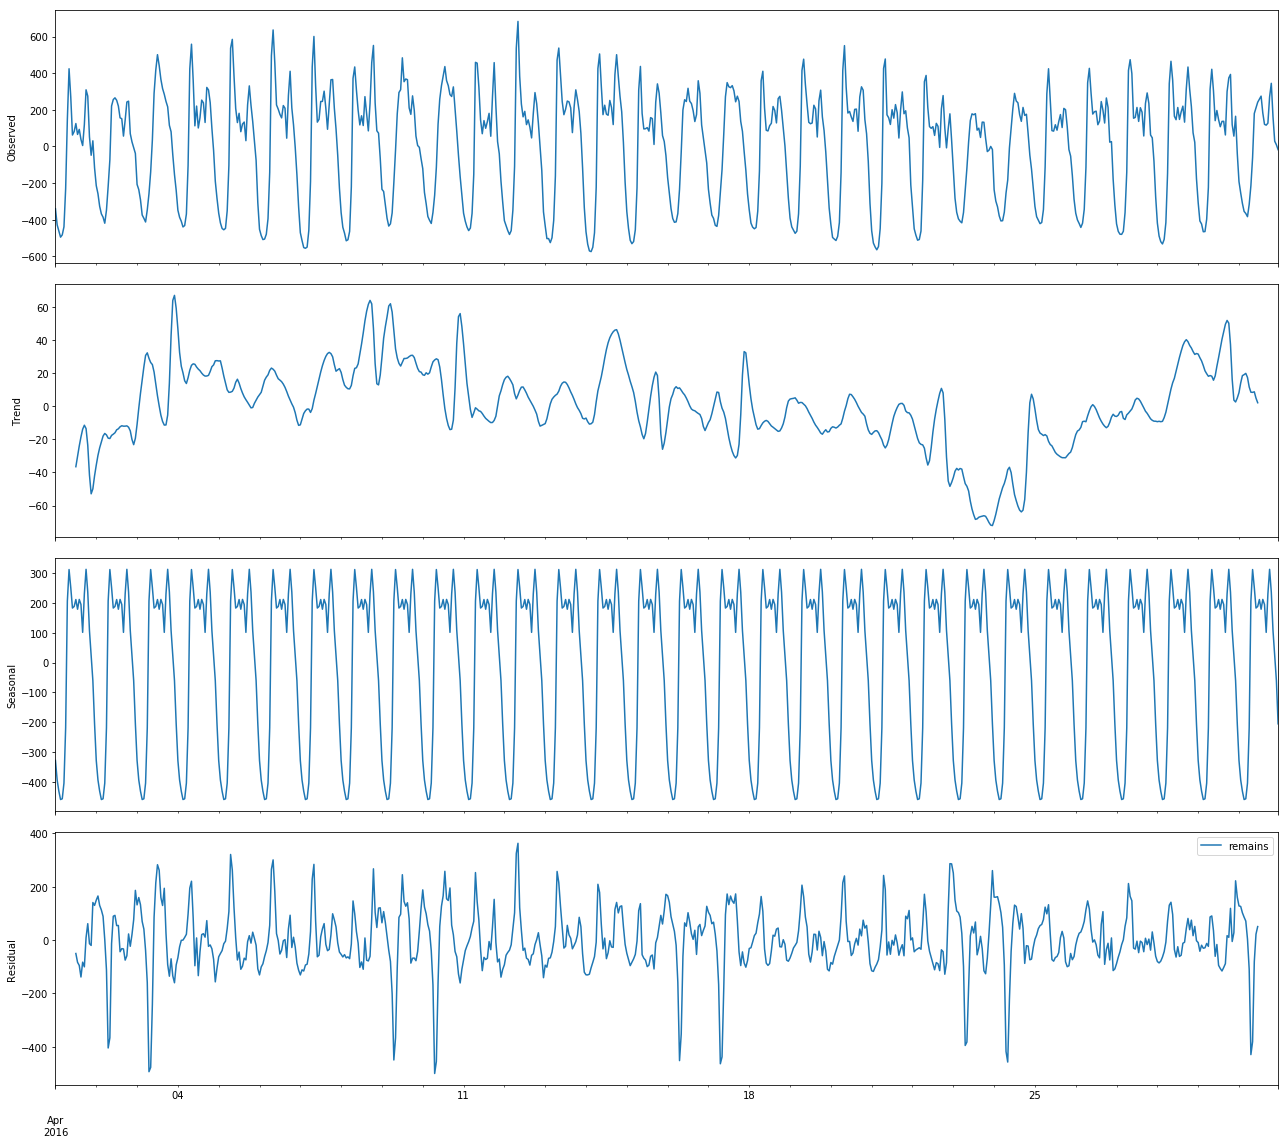

In [0]:
#анализ остатков
figure(figsize(18,16))
sm.tsa.seasonal_decompose(df[0].remains).plot()
legend()
show()

In [0]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df[0].remains)[1])

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

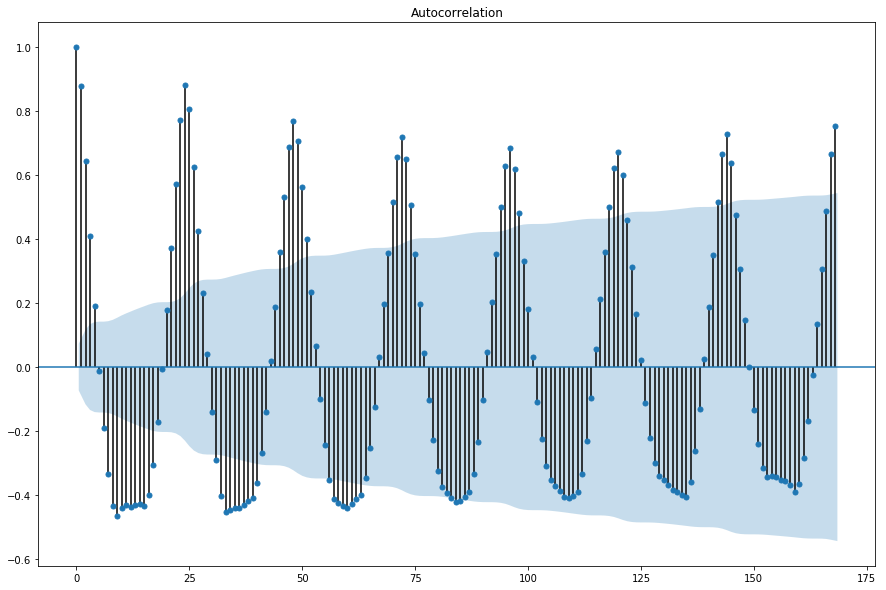

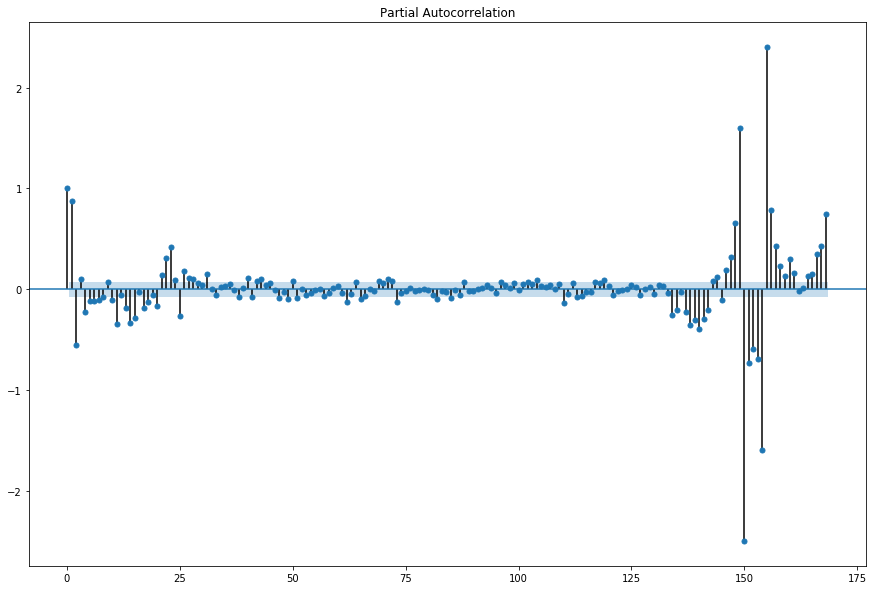

In [0]:
#ACF и PACF полученного ряда остатков
figure(figsize(15,10))
sm.graphics.tsa.plot_acf(df[0].remains, lags=168)
sm.graphics.tsa.plot_pacf(df[0].remains, lags=168)
show()

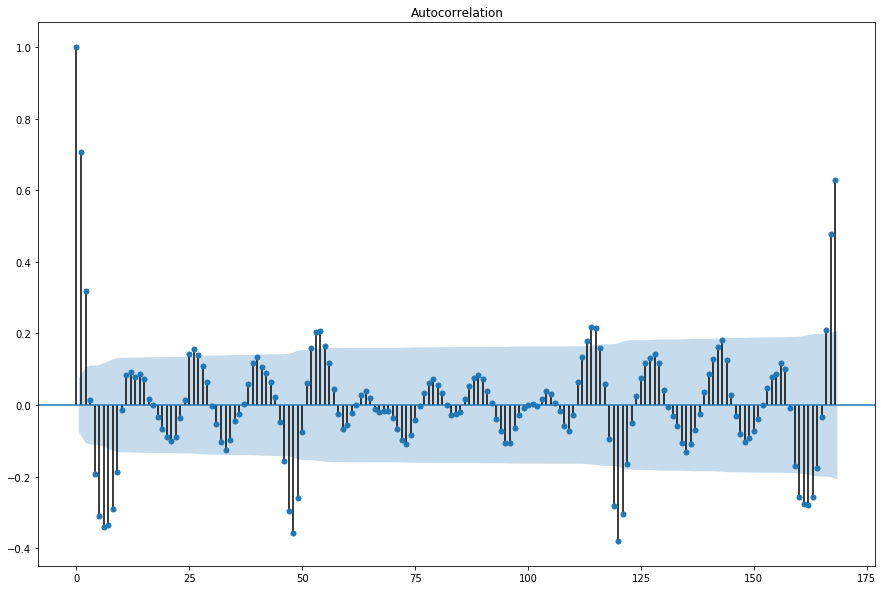

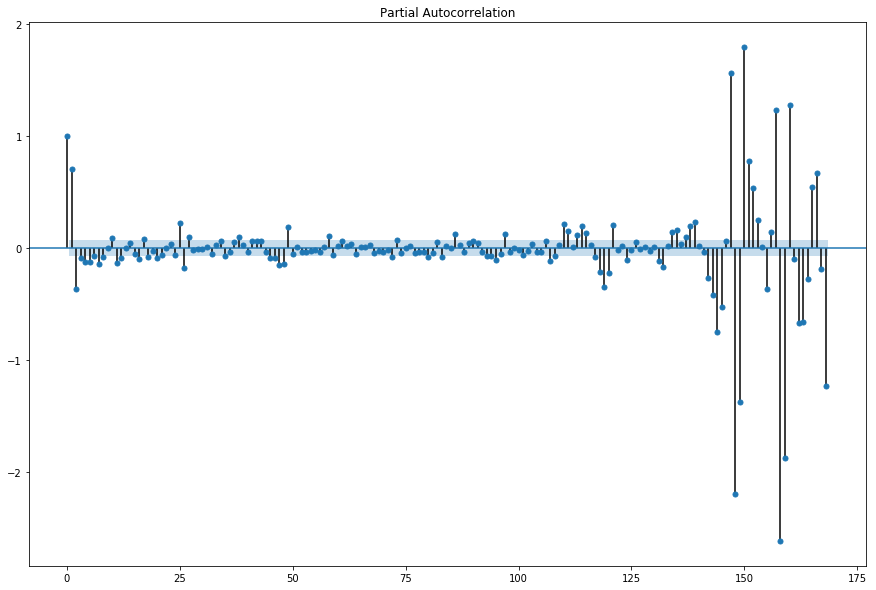

In [0]:
#применим диференцирование ряда со сдвигом на 24 часа
df[0]['shift_24'] = df[0].remains - df[0].remains.shift(24)

sm.graphics.tsa.plot_acf(df[0]['shift_24'].dropna(), lags=168)
sm.graphics.tsa.plot_pacf(df[0]['shift_24'].dropna(), lags=168)
show()

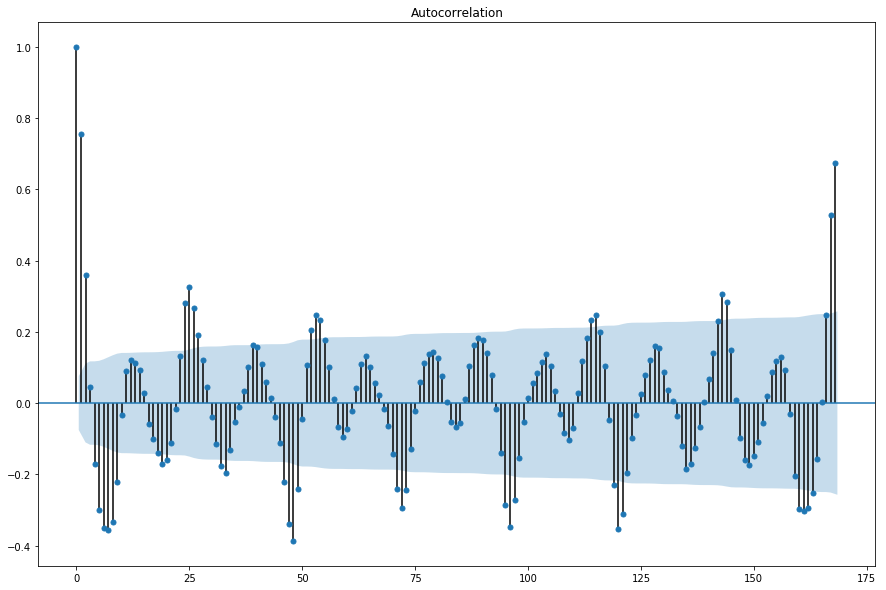

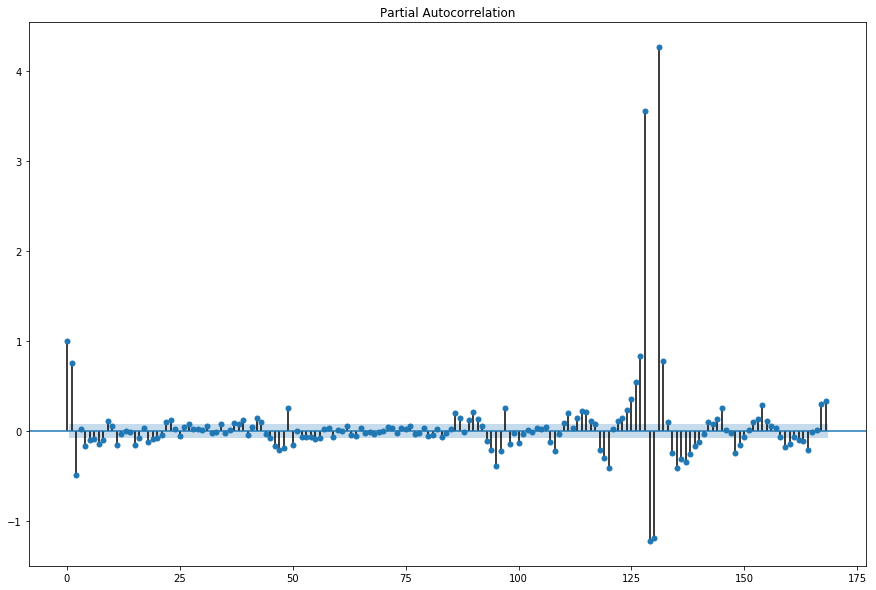

In [0]:
#применим диференцирование ряда со сдвигом на 24 часа
df[0]['shift_48'] = df[0].remains - df[0].remains.shift(48)

sm.graphics.tsa.plot_acf(df[0]['shift_48'].dropna(), lags=168)
sm.graphics.tsa.plot_pacf(df[0]['shift_48'].dropna(), lags=168)
show()

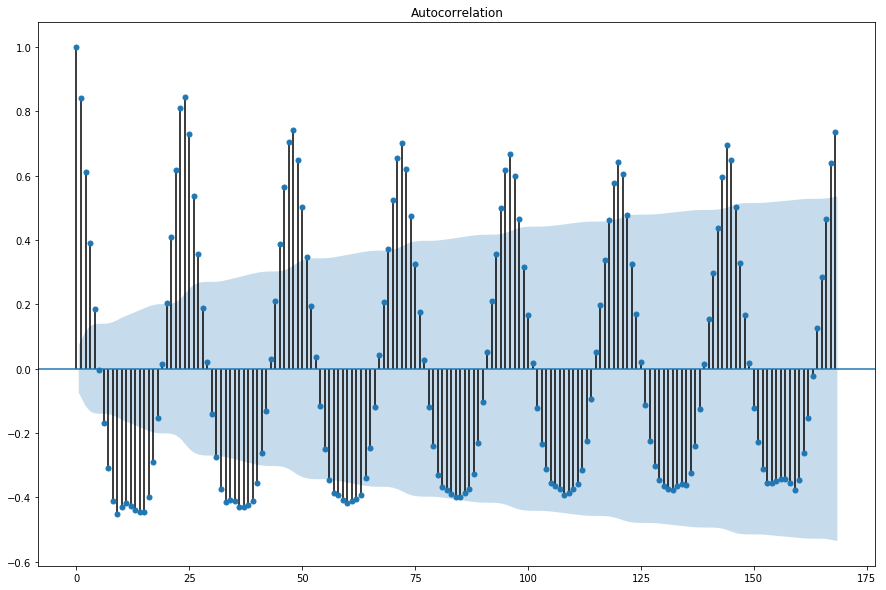

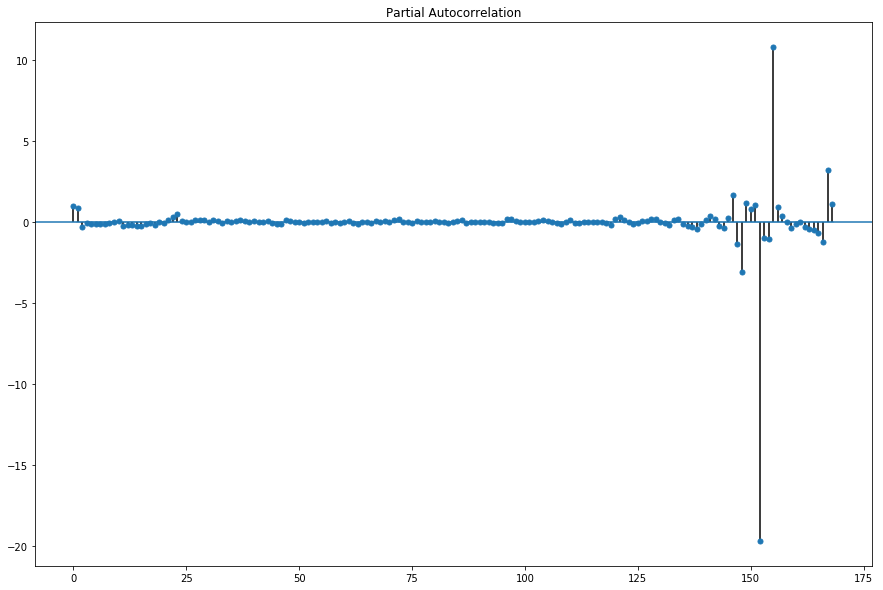

In [0]:
#применим диференцирование ряда со сдвигом на 24 часа
df[0]['shift_24_1'] = df[0].shift_24 - df[0].remains.shift(1)

sm.graphics.tsa.plot_acf(df[0]['shift_24_1'].dropna(), lags=168)
sm.graphics.tsa.plot_pacf(df[0]['shift_24_1'].dropna(), lags=168)
show()

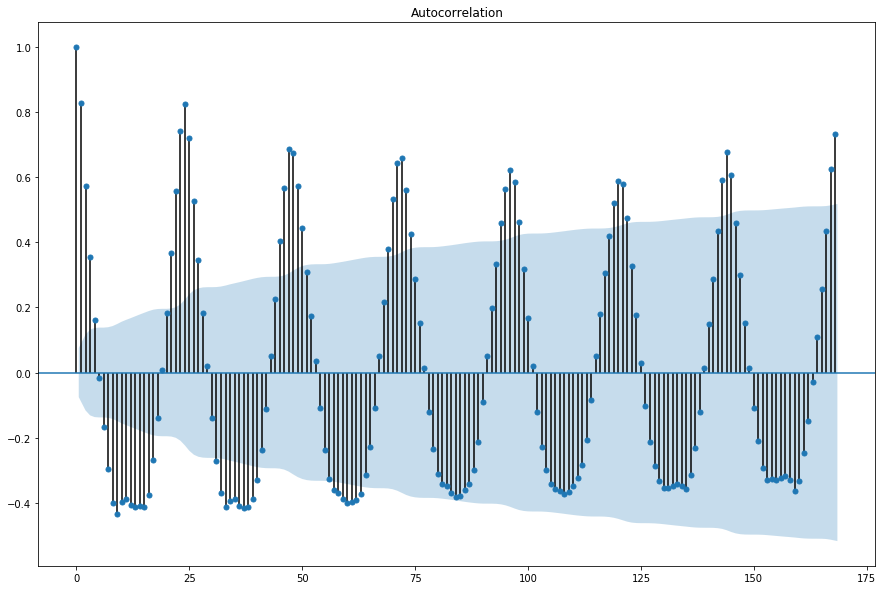

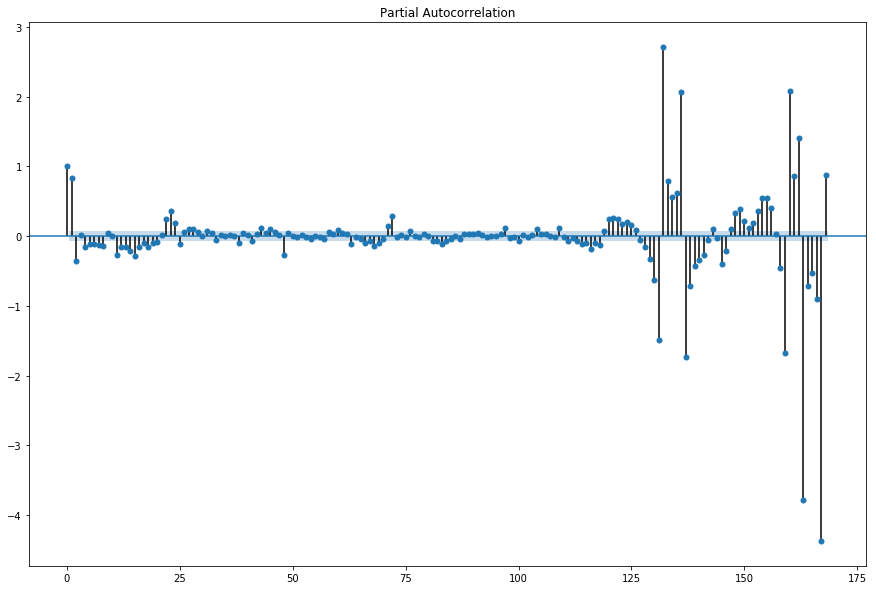

In [0]:
#применим диференцирование ряда со сдвигом на 24 часа
df[0]['shift_48_1'] = df[0].shift_48 - df[0].remains.shift(1)

sm.graphics.tsa.plot_acf(df[0]['shift_48_1'].dropna(), lags=168)
sm.graphics.tsa.plot_pacf(df[0]['shift_48_1'].dropna(), lags=168)
show()

Диференцирование ряда остатков не убирает сезонность из модели

####6. 1. Для каждой из R географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны.

In [0]:
#Диапазон значения для моделей

import warnings
from itertools import product

ps = range(0, 3)
d  = 0
qs = range(0, 3)
Ps = range(0, 2)
D  = 1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print "MODELS: ", len(parameters_list)

MODELS:  36


In [0]:
parameters_list = list([[2, 2, 1, 1]])

In [0]:
#Перебор моделей
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
  try:
      model=sm.tsa.statespace.SARIMAX(df[0][series[0]].dropna(),
                                      exog = features[col_models[0]], 
                                      order=(param[0], d, param[1]), 
                                      seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
  except Exception:
    print('Exception: ', param)
    continue        
  else:
    print(param, model.aic)
  aic = model.aic
  if aic < best_aic:
      best_model = model
      best_aic = aic
      best_param = param
  results.append([param, model.aic])
  
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

print(best_model.summary())

([2, 2, 1, 1], 8015.388209526738)
     parameters         aic
0  [2, 2, 1, 1]  8015.38821
                                 Statespace Model Results                                 
Dep. Variable:                        region_1333   No. Observations:                  720
Model:             SARIMAX(2, 0, 2)x(1, 1, 1, 24)   Log Likelihood               -3988.694
Date:                            Sat, 17 Aug 2019   AIC                           8015.388
Time:                                    07:08:21   BIC                           8101.750
Sample:                                04-01-2016   HQIC                          8048.781
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1        -33.3818   

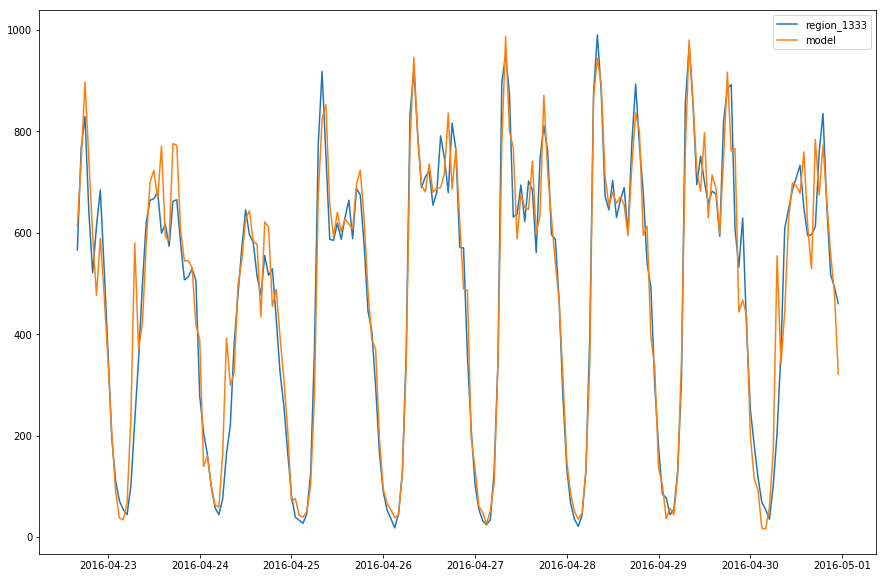

In [0]:
#df[0]['model'] = best_model.fittedvalues + df[0].predict
df[0]['model'] = best_model.fittedvalues

figure(figsize=(15,10))
plot(df[0].index[-200:],df[0][series[0]][-200:])
plot(df[0].index[-200:],df[0].model[-200:])
legend()
show()

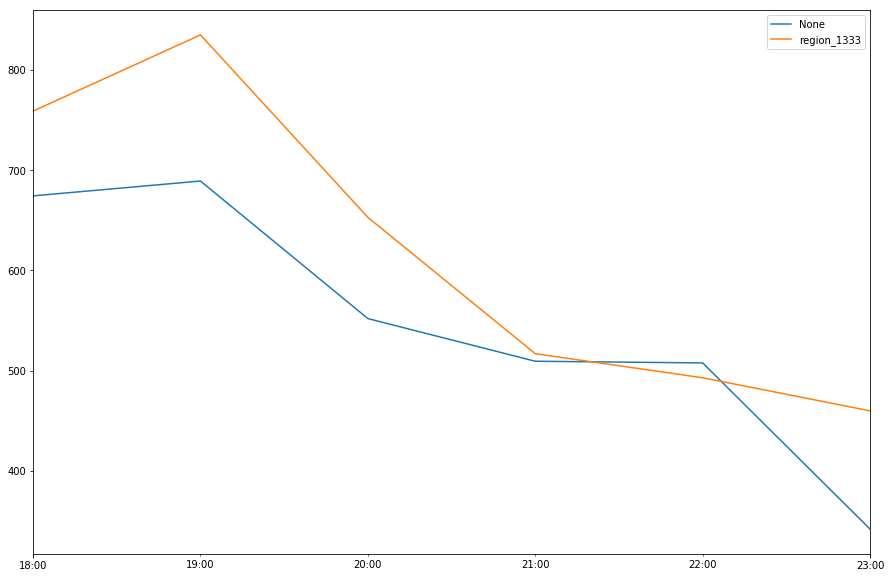

In [0]:
from datetime import timedelta
#Предсказанире на 6 часов
model_fitted = sm.tsa.statespace.SARIMAX(df[0][series[0]],
                                      exog = features[col_models[0]],
                                      order=(2, 0, 2), 
                                      seasonal_order=(1, 1, 1, 24)).filter(params = best_model.params)


time_start = df[0].index[-1] - timedelta(hours=1) * 5 
h = timedelta(hours=1)
forecast = model_fitted.predict(time_start, time_start + h * 5, dynamic=True)
forecast.plot()
df[0][series[0]][-6:].plot()
legend()
show()

In [0]:
#Загрузить данные с апреля по июнь 2016
filepath = '/content/gdrive/My Drive/ml/'
month = ['2016-4' ,'2016-5' ,'2016-6']
month_arr = []
for m in range(len(month)):
  filename = str(month[m]) + str('.csv')
  data = pd.read_csv(filepath + filename, index_col = 0)
  month_arr.append(pd.DataFrame(data, index = [datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data.index]))

data = pd.concat(month_arr)

data.drop(rem, axis='columns', inplace=True)

In [0]:
#Создать признаки features для exog на все месяцы
#Количество создаваемых признаков
k_features = 10
k_poly = 0

#Столбцы
col = []
  
for i in range(1, k_features + 1):
  col.append(str('sin_' + str(i)))
  col.append(str('cos_' + str(i)))
for i in range(1, k_poly + 1):
  col.append(str('poly_' + str(i)))

#Признаки
features = pd.DataFrame(columns = col, index = data.index)

features['num'] = [int(i) for i in range(1, len(data) + 1)]
for k in range(1, k_features + 1):
  features[str('sin_' + str(k))] = [np.sin(features.num[x] * 2 * np.pi * k / 168) for x in range(len(data))]
  features[str('cos_' + str(k))] = [np.cos(features.num[x] * 2 * np.pi * k / 168) for x in range(len(data))]
  
for k in range(1, k_poly + 1):
  features[str('poly_' + str(k))] = [features.num[x] ** k  for x in range(len(data))]

features = features.drop(columns = 'num')  

In [0]:
#Создать датафрейм для значений predict линейной регрессии для всех регионов
df_predict = pd.DataFrame(index = data.index, columns = data.columns)
df_remains = pd.DataFrame(index = data.index, columns = data.columns)

In [0]:
#обучить линейную регрессию на данных за апрель(!)
train_features = features[features.index < '2016-05-01 00:00:00']

#построить для всех 102 регионов
for i in range(len(data.columns)):
  train_data = data[data.index < '2016-05-01 00:00:00'][data.columns[i]]
  X = np.array(train_features)
  Y = np.array(train_data)
  lin_reg = linear_model.LinearRegression()
  lin_reg.fit(X,Y)
  df_predict[data.columns[i]] = lin_reg.predict(features)
  df_remains[data.columns[i]] = data[data.columns[i]] - df_predict[data.columns[i]]

In [0]:
#обучить SARIMAX на остатках(!) за апрель(!): 7 рядов(по кластерам)
def fit_model(data, parameters_list):
  d = 0
  D = 1
  results = []
  best_aic = float("inf")
  warnings.filterwarnings('ignore')
  
  for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data,
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except Exception:
      print('Exception: ', param)
      continue        
    else:
      print(param, model.aic)
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
  warnings.filterwarnings('default')
  
  result_table = pd.DataFrame(results)
  result_table.columns = ['parameters', 'aic']
  
  return best_model

parameters_list = list([[2, 2, 1, 1]])

model_list = []

for i in range(len(series)):
  train_data = df_remains[data.index < '2016-05-01 00:00:00'][series[i]]
  model_list.append(fit_model(train_data, parameters_list))

([2, 2, 1, 1], 7877.41719942983)
([2, 2, 1, 1], 7760.0342845490595)
([2, 2, 1, 1], 7637.801359789222)
([2, 2, 1, 1], 7519.228094441128)
([2, 2, 1, 1], 5076.283638882418)
([2, 2, 1, 1], 4479.572387345912)
([2, 2, 1, 1], 3799.0830688092365)


In [0]:
start = data[data.index < '2016-05-01 00:00:00'].index[-1]
h = timedelta(hours=1)

In [0]:
#Загружаем в модель полученные на обучении параметры и данные для построения прогноза
model_fitted = sm.tsa.statespace.SARIMAX(df_remains[series[0]],
                                      order=(2, 0, 2), 
                                      seasonal_order=(1, 1, 1, 24)).filter(params = model_list[0].params)

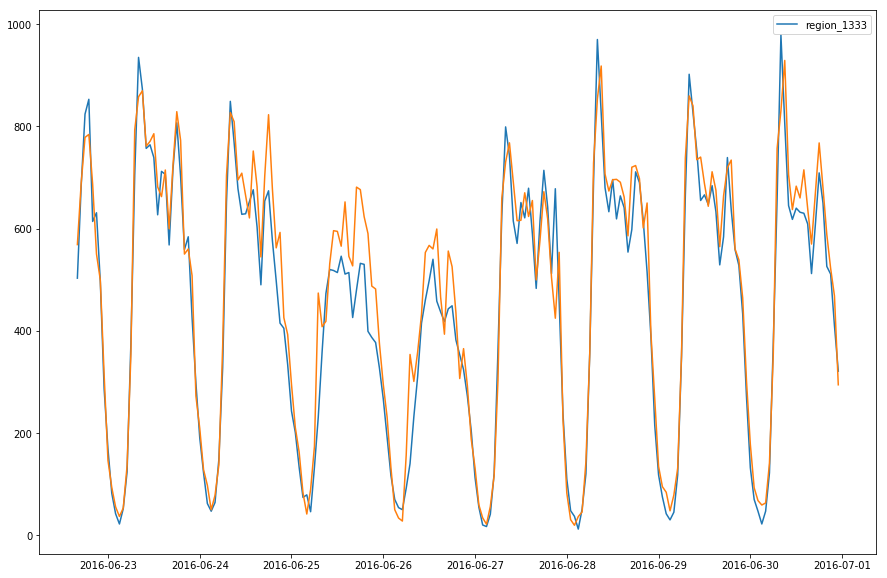

In [0]:
figure(figsize=(15,10))
plot(data.index[-200:],data[series[0]][-200:])
plot(data.index[-200:],model_fitted.fittedvalues[-200:] + df_predict[series[0]][-200:])
legend()
show()

####6.2.  Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза.

In [0]:
start = data[data.index < '2016-05-01 00:00:00'].index[-1] + timedelta(hours=1)
h = timedelta(hours=1)

In [0]:
for k in range(len(c)):   #для кластеров 0 1 2 3 4 5 6
  Q_may = []
  for j in range(len(cl[k])): #для регионов кластера
    model_fitted = sm.tsa.statespace.SARIMAX(df_remains[cl[k][j]], #прогноз по remains текущего(!) региона
                                      order=(2, 0, 2), 
                                      seasonal_order=(1, 1, 1, 24)).filter(params = model_list[k].params)
    for i in range(739): #для концов истории    
      forecast = np.array(df_predict[(data.index >= start + i * h) & (data.index <= start + (i + 5) * h)][cl[k][j]]) + np.array(model_fitted.predict(start + i * h, start + (i + 5) * h, dynamic=True))
      forecast = forecast * (forecast > 0)
      actual   = np.array(data[(data.index >= start + i * h) & (data.index <= start + (i + 5) * h)][cl[k][j]])
      Q_may.append(sum(abs(forecast - actual)))
      
  ans = sum(Q_may)
  
  path = '/gdrive/My Drive/ml/'
  name = str('cluster_' + str(k) + '.txt')
  
  drive.mount('/content/gdrive')
  with open(path + name, 'w') as f:
    f.write(str(ans))

In [0]:
#Считать файлы в цикле и вычислить Q_may
path = '/content/gdrive/My Drive/ml/'
name = 'cluster_'

q = []

for i in range(7):
  f = open(path + name + str(i) + '.txt')
  q.append(float(f.readline()))
  f.close()

Q = sum(q) / (6 * 739 * 102)
print(Q)

26.88787778034579


####7. Для каждой из R географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате (id, y), где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

In [0]:
#обучить линейную регрессию на данных за апрель-май(!)
train_features = features[features.index < '2016-06-01 00:00:00']

#построить для всех 102 регионов
for i in range(len(data.columns)):
  train_data = data[data.index < '2016-06-01 00:00:00'][data.columns[i]]
  X = np.array(train_features)
  Y = np.array(train_data)
  lin_reg = linear_model.LinearRegression()
  lin_reg.fit(X,Y)
  df_predict[data.columns[i]] = lin_reg.predict(features)
  df_remains[data.columns[i]] = data[data.columns[i]] - df_predict[data.columns[i]]

In [0]:
#обучить SARIMAX на остатках(!) за апрель-май(!): 7 рядов(по кластерам)
def fit_model(data, parameters_list):
  d = 0
  D = 1
  results = []
  best_aic = float("inf")
  warnings.filterwarnings('ignore')
  
  for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data,
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except Exception:
      print('Exception: ', param)
      continue        
    else:
      print(param, model.aic)
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
  warnings.filterwarnings('default')
  
  result_table = pd.DataFrame(results)
  result_table.columns = ['parameters', 'aic']
  
  return best_model

parameters_list = list([[2, 2, 1, 1]])

model_list = []

for i in range(len(series)):
  train_data = df_remains[data.index < '2016-06-01 00:00:00'][series[i]]
  model_list.append(fit_model(train_data, parameters_list))

([2, 2, 1, 1], 16396.43513408328)
([2, 2, 1, 1], 15975.717043047869)
([2, 2, 1, 1], 15680.54890603065)
([2, 2, 1, 1], 15551.001215993616)
([2, 2, 1, 1], 10491.019622997308)
([2, 2, 1, 1], 9173.570725178932)
([2, 2, 1, 1], 7731.024294009872)


In [0]:
start = data[data.index < '2016-06-01 00:00:00'].index[-1]
h = timedelta(hours=1)

In [0]:
#список просчитанных регионов:
import os

path = '/content/gdrive/My Drive/ml/regions/'
fl = []
for filename in os.listdir(path):
  reg = 'region_' + filename[:-4]
  fl.append(reg)

In [0]:
for k in range(len(cl)):   #для кластеров 0 1 2 3 4 5 6
  iter_cnt = 0
  for j in range(len(cl[k])): #для регионов кластера
    df = pd.DataFrame(columns = ['id', 'y'])
    model_fitted = sm.tsa.statespace.SARIMAX(df_remains[cl[k][j]], #прогноз по remains текущего(!) региона
                                      order=(2, 0, 2), 
                                      seasonal_order=(1, 1, 1, 24)).filter(params = model_list[k].params)
    for i in range(715): #для концов истории    
      forecast = np.array(df_predict[(data.index >= start + i * h) & (data.index <= start + (i + 5) * h)][cl[k][j]]) + np.array(model_fitted.predict(start + i * h, start + (i + 5) * h, dynamic=True))
      forecast = forecast * (forecast > 0)
      
      for n in range(1, 7):
        id_str = str(cl[k][j][7:]) + str('_') + str(start + h)[:-9] + str('_')+ str((start + i * h + h).hour) + str('_') + str(n)
        df.loc[iter_cnt] = [id_str, forecast[n - 1]]
        iter_cnt += 1
    
    drive.mount('/content/gdrive')
    df.to_csv('/content/gdrive/My Drive/ml/regions/' + str(cl[k][j][7:]) + '.csv')

In [0]:
#437580  строк
import os

filepath = '/content/gdrive/My Drive/ml/regions_new/'
fl = []
for filename in os.listdir(path):
  fl.append(filename)

regions_arr = []  
for i in range(len(fl)):
  regions_arr.append(pd.read_csv(filepath + fl[i], index_col = 0))

data = pd.concat(regions_arr)

data.to_csv('/content/gdrive/My Drive/ml/regions_new/' + str('final_v4') + '.csv')

####8. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

135. Konstantin Shitkov 34.99237
https://inclass.kaggle.com/submissions/12160682/12160682.raw
